In [300]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import imutils
import os
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
pathToExecutable = (
    "C:/Program Files/GNU Octave/Octave-7.1.0/mingw64/bin/octave-cli.exe"
)
os.environ['OCTAVE_EXECUTABLE'] = pathToExecutable
from oct2py import octave
from detect_face import detect_face, FaceAligner
fa = FaceAligner(desiredFaceWidth=224)

In [135]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [267]:
dir = os.path.dirname(os.getcwd())

In [234]:
missing_imgs= ['missing/WhatsApp_Image_2022-05-29_at_7.jpeg', 'missing/WhatsApp_Image_2022-05-292.jpeg', 'missing/WhatsApp_Image_2022-05-28_at_1.12.12_PM.jpeg', 'missing/WhatsApp_Image_2022-05-28_at_1.12.11_PM.jpeg', 'missing/016A04.JPG', 'missing/016A05.JPG', 'missing/016A07.JPG', 'missing/053A10.JPG', 'missing/053A12.JPG']
missing_labels= ['KeerthanaK_2011-02-03', 'KeerthanaK_2011-02-03', 'AnsuiyaSharma_2007-05-07', 'AnsuiyaSharma_2007-05-07', 'AndySmith_2003-12-09', 'AndySmith_2003-12-09', 'AndySmith_2003-12-09', 'SanjayRaj_2020-05-09', 'SanjayRaj_2020-05-09']

In [235]:
missing_labels.append('check')
n_labels = len(set(missing_labels))
print(n_labels)

5


In [237]:

label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
missing_labels_en= label_encoder.fit_transform(missing_labels)

In [286]:
missing_labels_en

array([2, 2, 1, 1, 0, 0, 0, 3, 3, 4], dtype=int64)

In [10]:
model = tf.keras.applications.VGG16(
            include_top=True,
            weights="imagenet",
            input_tensor=None,
            input_shape=None,
            pooling=None,
            classes=1000,
            classifier_activation="softmax",
        )

In [191]:
def get_images_new(image_list, label_list,check_img):
    labels = np.zeros((1, len(missing_imgs)+1))
    i = 0
    images = []
    print(labels.shape)
    for filename in image_list:
        f=filename.split('/')
        img = cv2.imread(os.path.join(dir,'content','media',f[0],f[1]))
        img= cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        
        img= cv2.resize(img,(224,224))
        img2 = cv2.merge((img,img,img))
        img = img_to_array(img2)
        images.append(img2)
        labels[0][i] = label_list[i] #eg: 001 is the label stored
        i +=1
    labels[0][i] = label_list[i]
    check_img= cv2.equalizeHist(cv2.cvtColor(check_img, cv2.COLOR_BGR2GRAY))
    img= cv2.resize(check_img,(224,224))
    img2 = cv2.merge((img,img,img))
    img = img_to_array(img2)
    images.append(img)
    return np.array(images), labels

In [192]:
def feature_extraction(check_img):
    with tf.device('/device:cpu:0'):
       
    
        images, labels = get_images_new(missing_imgs,missing_labels_en,check_img)
        Flatten_list = [];
        FC7_list = [];
        FC6_list = [];
        labels_list = [];
        l = len(model.layers)
        for i in range(len(images)):
            image = images[i]
            img = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) 

            keras_function = K.function([model.get_layer(index=0).input], model.get_layer(index=l - 4).output)
            Flatten = keras_function([img])

            keras_function = K.function([model.get_layer(index=0).input], model.get_layer(index=l - 3).output)
            FC7 = keras_function([img])

            keras_function = K.function([model.get_layer(index=0).input], model.get_layer(index=l - 2).output)
            FC6 = keras_function([img])

            labels_list.append(labels[0][i])
            
            Flatten_list.append(Flatten[0])
            FC7_list.append(FC7[0])
            FC6_list.append(FC6[0])
    return labels_list,Flatten_list, FC7_list,FC6_list        

In [302]:
check_img = "WhatsApp Image 2022-05-29 at 7.00.18 PM (2).jpeg"
faces = detect_face(check_img)

In [303]:
face = faces[0]
aligned_img =  fa.align(cv2.imread(check_img), face['keypoints']['left_eye'], face['keypoints']['right_eye'])

In [243]:
labels,Flatten, FC7, FC6 = feature_extraction(aligned_img)

(1, 10)


In [244]:
print(len(Flatten[0]), len(labels),len(FC6[0]))


25088 10 4096


In [268]:
images_encoded = model.predict(images)

In [272]:
len(images_encoded)
images_encoded.shape


(10, 1000)

In [304]:
images_encoded_new=pcaFuse(images_encoded,len(images_encoded))

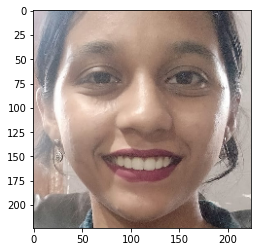

In [293]:
plt.figure()
plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)) 
plt.show()

In [305]:
clf.fit(images_encoded_new[:-1],labels[:-1])

SVC(C=2, kernel='linear')

In [306]:
clf.predict(images_encoded_new)

array([0., 2., 0., 0., 0., 0., 0., 0., 0., 0.])

In [274]:
n=len(Flatten)
flatten_new=pcaFuse(Flatten,n)
fc7_new=pcaFuse(FC7,n)
fc6_new=pcaFuse(FC6,n)

In [260]:

t=octave.fuse(flatten_new,fc7_new,fc6_new,labels)

In [247]:
t.shape

(10, 4)

In [251]:

#print(datas, len(datas),len(datas[0]))
#print(each_person)
X_train, X_test, y_train, y_test = train_test_split(
        datas[:-1], labels[:-1], test_size=0.30, random_state=49)

In [264]:
clf = svm.SVC(kernel='linear', C=2)

In [298]:
clf.fit(datas[:-4],labels[:-4])

SVC(C=2, kernel='linear')

In [299]:
clf.predict(datas)

array([2., 2., 1., 1., 0., 0., 0., 0., 0., 0.])

In [228]:
datas[-1]

array([ 9.52181819e-08, -2.44064931e-08, -1.95574177e-07,  9.66642480e-08,
       -5.66531749e-08])